In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root

In [2]:
TFtot = 2000
kon = 0.0016399
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA, Protein = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - TFon) - koff * TFon
    dmRNAdt = kbasal + kmax * (TFon ** n) / ((Kd ** n) + (TFon ** n)) - kdegR * mRNA
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)
    dProteindt = ktrans * mRNA - kdegP * Protein   

    return [dTFondt, dmRNAdt, dProteindt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,:] - x[:])
    return (sol.y[:,-1] - x) * [1/10,10,1/10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [100,u, 10000]

    # tspan = [0,100]
    # sol = solve_ivp(khammash_ode, t_span=tspan, y0=x_guess, args=(p,I),
    #                     rtol=1e-9, atol=1e-12, 
    #                     # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
    #                     method='BDF',
    #                     first_step = 0.0001,
    #                     max_step=u*period,
    #                     )
    # x_guess = sol.y[:,-1]

    print('my guess is')
    print(x_guess)
    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10
    sol = root(fsolve_func, x_guess, args=(period,I,max_step), tol=1e-6)

    # if ier != 1:
    #     x_guess = [1000,u, 1000]
    #     sol, _, ier, mesg = fsolve(fsolve_func, x_guess, args=(period,I), xtol=1e-6, full_output=True)
    # print('=======================')
    # print(x_guess)
    # print(ier)    
    # print(mesg)
    # print(sol)
    # print('=======================')

    steady = np.maximum(sol.x,[0,0,0])

    return steady, sol.success, sol.message, sol.fun

def khammash_ode_simple(t,x,p,u, period, Imax):

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    x_guess = x
    global setpoint
    if setpoint is None:
        out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    else:
        out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)
    tau_TF = 1 / koff
    tau_mRNA = 1 / kdegR
    tau_Protein = 1 / kdegP

    # Variables
    TFon, mRNA, Protein = x
    TFon = np.max([0,TFon])
    # mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = (out[0] - TFon) / tau_TF
    dmRNAdt = (out[1] - mRNA) / tau_mRNA
    # dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax) 
    dProteindt = (out[2] - Protein) / tau_Protein

    return [dTFondt, dmRNAdt, dProteindt]


my guess is
[100, 0.0, 10000]
steady fun out
[0.00000000e+00 1.91859628e-03 1.28592350e+02]
True
The solution converged.
[0.00000000e+00 4.11996826e-17 0.00000000e+00]


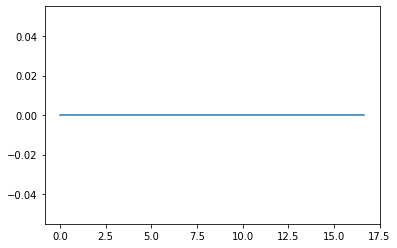

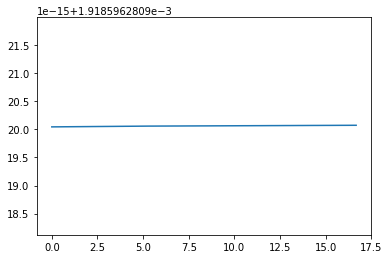

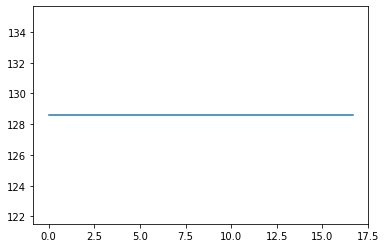

In [3]:
import matplotlib.pyplot as plt

u = 0.
period = 100 / 60
Imax = 10000

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

out, ier, mesg, fun_val = steady_mRNA_solve(u, period, Imax)
print('steady fun out')
print(out)
print(ier)
print(mesg)
print(fun_val)
# out = sol.y[:,-1]

tspan = np.array([0, period*10])
I = lambda t: I_fun_base(t, u, period, Imax)
sol = solve_ivp(khammash_ode, t_span=tspan, y0=out, args=(p,I),
                    rtol=1e-9, atol=1e-12, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0000001,
                    max_step=max_step,
                    )

plt.figure()
plt.plot(sol.t, sol.y[0])

plt.figure()
plt.plot(sol.t, sol.y[1])

plt.figure()
plt.plot(sol.t, sol.y[2])

In [10]:
I = 400

t_span_base = np.array([0, 200])
tspan = t_span_base.copy()

u_arr = [0.9, 0.01, 0.1, 0.5, 1., 0, 0.03]
# u_arr = [0., 0.03 ]
x_init = [0,0,0]
x_init_simple = x_init

TFon_arr = []
mRNA_arr = []
Protein_arr = []
t_arr = []

TFon_arr_simple = []
mRNA_arr_simple = []
Protein_arr_simple = []
t_arr_simple = []

setpoint = None

for i in range(len(u_arr)):
    u = u_arr[i]
    print(u)
    period = 1000 / 60
    Imax = 10000

    out, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)


    tspan_average = np.array([0, period])
    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(khammash_ode, t_span=tspan_average, y0=out, args=(p,I),
                        rtol=1e-6, atol=1e-9, 
                        t_eval=np.linspace(tspan_average[0], tspan_average[1], 1000), 
                        method='BDF',
                        first_step = np.min((0.1, max_step/10)),
                        max_step=max_step,
                        )

    setpoint = np.trapz(sol.y, sol.t, axis=1) / period

    print('my setpoint')
    print(ier)
    print(mesg)
    print(setpoint)

    print('my inits')
    print(x_init)
    print(x_init_simple)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10


    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x_init, args=(p,I),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )

    print(sol.status)
    print(sol.message)
    print(sol.success)

    sol_simple = solve_ivp(khammash_ode_simple, t_span=tspan, y0=x_init_simple, args=(p,u,period,Imax),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )

    print(sol_simple.status)
    print(sol_simple.message)
    print(sol_simple.success)

    tspan = t_span_base.copy() + tspan[-1]

    TFon_arr.append(sol.y[0])
    mRNA_arr.append(sol.y[1])
    Protein_arr.append(sol.y[2])
    t_arr.append(sol.t)

    TFon_arr_simple.append(sol_simple.y[0])
    mRNA_arr_simple.append(sol_simple.y[1])
    Protein_arr_simple.append(sol_simple.y[2])
    t_arr_simple.append(sol_simple.t)

    x_init = sol.y[:,-1]
    x_init_simple = sol_simple.y[:,-1]

print('my inits')
print(x_init)
print(x_init_simple)

TFon_arr = np.concatenate(TFon_arr)
mRNA_arr = np.concatenate(mRNA_arr)
Protein_arr = np.concatenate(Protein_arr)
t_arr = np.concatenate(t_arr)

TFon_arr_simple = np.concatenate(TFon_arr_simple)
mRNA_arr_simple = np.concatenate(mRNA_arr_simple)
Protein_arr_simple = np.concatenate(Protein_arr_simple)
t_arr_simple = np.concatenate(t_arr_simple)

0.9
my guess is
[100, 0.9, 10000]
my setpoint
True
The solution converged.
[1.95583367e+03 9.41416754e-01 6.30828553e+04]
my inits
[0, 0, 0]
[0, 0, 0]
0
The solver successfully reached the end of the integration interval.
True
0
The solver successfully reached the end of the integration interval.
True
0.01
my guess is
[100, 0.01, 10000]
my setpoint
True
The solution converged.
[3.32705051e+02 1.25131834e-01 8.38685159e+03]
my inits
[1.95891639e+03 9.51872744e-01 4.47607817e+04]
[1.95583367e+03 9.41209293e-01 4.75268142e+04]
0
The solver successfully reached the end of the integration interval.
True
0
The solver successfully reached the end of the integration interval.
True
0.1
my guess is
[100, 0.1, 10000]
my setpoint
True
The solution converged.
[5.28649452e+02 2.21121193e-01 1.48203785e+04]
my inits
[6.31015545e+00 9.23761671e-02 2.01917741e+04]
[3.32705051e+02 1.25311134e-01 1.80386475e+04]
0
The solver successfully reached the end of the integration interval.
True
0
The solver succ

In [11]:
print(tspan)

[1400 1600]


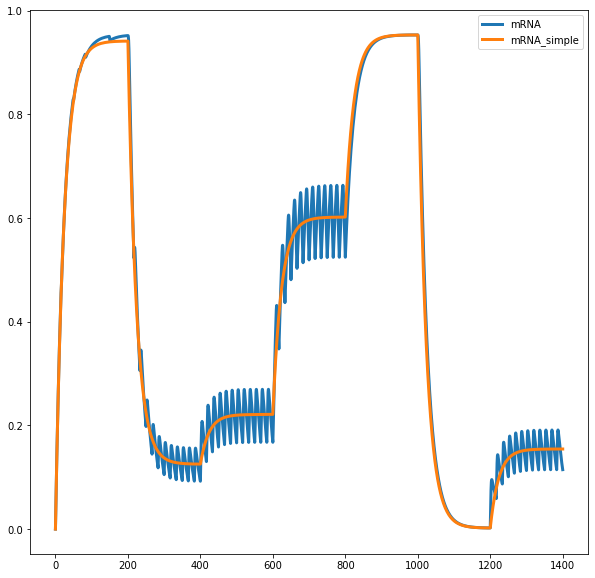

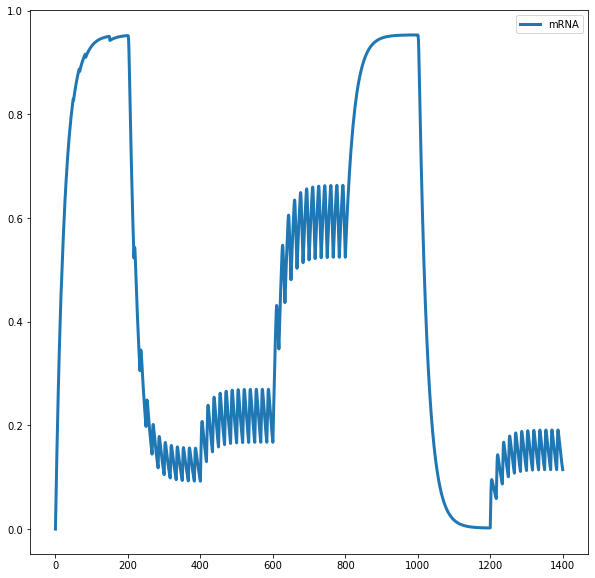

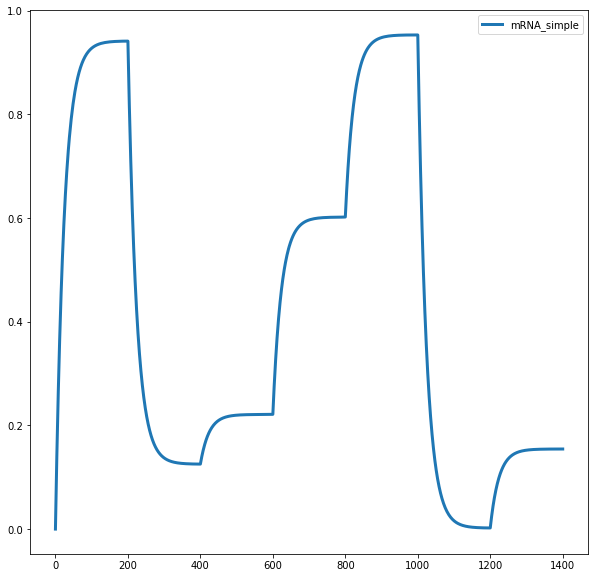

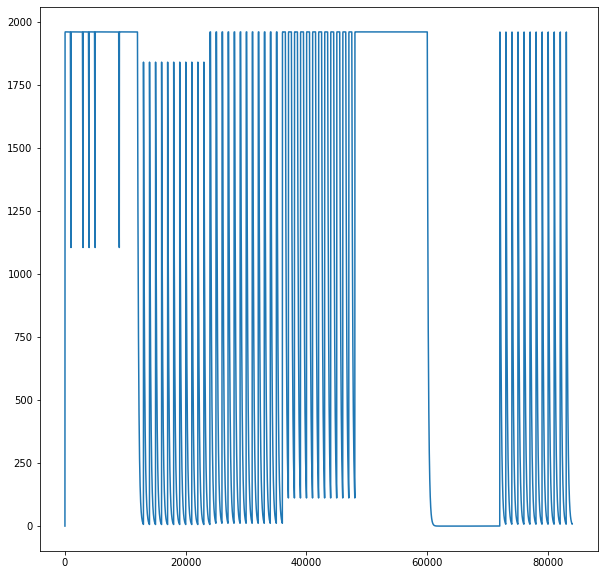

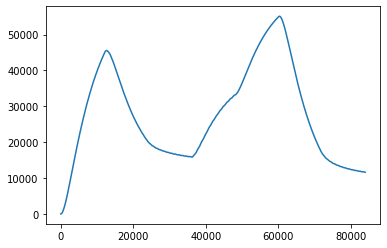

In [12]:
import matplotlib.pyplot as plt

plt.figure(facecolor='white', figsize=(10,10))
plt.plot(t_arr, mRNA_arr, label='mRNA', linewidth=3)
plt.plot(t_arr_simple, mRNA_arr_simple, label='mRNA_simple', linewidth=3)
# plt.plot(t_arr*60, I(t_arr)/Imax, label='I', linewidth=3)
# plt.plot(np.linspace(t_arr[0],t_arr[-1],10000)*60, I(np.linspace(t_arr[0],t_arr[-1],10000))/Imax, label='I', linewidth=3)
plt.legend()

plt.figure(facecolor='white', figsize=(10,10))
plt.plot(t_arr, mRNA_arr, label='mRNA', linewidth=3)
# plt.plot(t_arr_simple*60, mRNA_arr_simple, label='mRNA_simple', linewidth=3)
# plt.plot(t_arr*60, I(t_arr)/Imax, label='I', linewidth=3)
# plt.plot(np.linspace(t_arr[0],t_arr[-1],10000)*60, I(np.linspace(t_arr[0],t_arr[-1],10000))/Imax, label='I', linewidth=3)
plt.legend()

plt.figure(facecolor='white', figsize=(10,10))
# plt.plot(t_arr*60, mRNA_arr, label='mRNA', linewidth=3)
plt.plot(t_arr_simple, mRNA_arr_simple, label='mRNA_simple', linewidth=3)
# plt.plot(t_arr*60, I(t_arr)/Imax, label='I', linewidth=3)
# plt.plot(np.linspace(t_arr[0],t_arr[-1],10000)*60, I(np.linspace(t_arr[0],t_arr[-1],10000))/Imax, label='I', linewidth=3)
plt.legend()

plt.figure(facecolor='white', figsize=(10,10))
plt.plot(t_arr*60, TFon_arr, label='TFon')

plt.figure(facecolor='white')
plt.plot(t_arr*60, Protein_arr, label='Protein')